In [1]:
%load_ext autoreload
%autoreload 2
from dpe import DPE
from lib_data import *
import matplotlib.pyplot as plt
import numpy as np
from lib_nn_dpe import NN_dpe
from IPython import display

load_workspace(vars(), 'dataset/20190815-132601-weights')
load_workspace(vars(), 'dataset/mnist')

Loaded: weights, 
Loaded: train_images, train_labels, test_images, test_labels, 


In [2]:
dpe = DPE()

Connecting to serial
DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
[INFO] Elapsed time = 0.03s
Serial disconnected


In [3]:
dpe.set_clock(50)

Connecting to serial
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz
[INFO] Elapsed time = 0.00s
Serial disconnected


In [4]:
g = dpe.read(1)

Connecting to serial
[INFO] Elapsed time = 0.25s
Serial disconnected


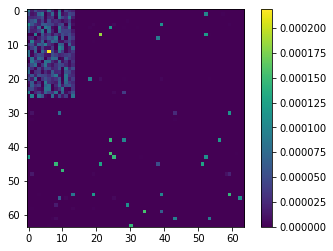

In [5]:
plt.imshow(g)
plt.colorbar()

In [6]:
nn = NN_dpe(weights)

In [41]:
img_idx = 6

image = test_images[img_idx]
vectors = nn._conv_flattern(image)
vectors.max()

1.0

In [42]:
outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / nn.Gratio

Connecting to serial
[INFO] Elapsed time = 1.48s
Serial disconnected


In [43]:
outputs.shape

(400, 14)

In [44]:
linear_factors_conv = [
       [ 1.40307296e+01, -2.58173509e-05],
       [ 1.41033398e+01,  5.21875110e-05],
       [ 1.55031527e+01,  1.58425174e-05],
       [ 1.54161942e+01, -9.61619642e-05],
       [ 1.32260040e+01,  1.93861940e-05],
       [ 1.40131446e+01,  1.06075518e-04],
       [ 1.17492652e+01, -2.25368275e-05],
       [ 1.45670486e+01, -4.82399742e-05],
       [ 1.36731289e+01,  1.02902647e-04],
       [ 1.45841854e+01, -3.02688972e-05],
       [ 1.57162630e+01,  4.17033681e-05],
       [ 1.60243388e+01,  4.15976155e-05],
       [ 1.64551436e+01,  2.55184336e-05],
       [ 1.61364337e+01, -7.45189375e-05]]

for c in range(outputs.shape[1]):
    outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]

In [45]:
result = outputs[:, ::2] - outputs[:,1::2]
x = result.reshape(20,20,-1)
# for i in range(7):
#     plt.figure(i)
#     plt.imshow(x[:,:,i])
#     plt.colorbar()

In [46]:
x1 = nn.relu(x)
x1 = nn.max_pooling(x1)
x1 = nn.flattern(x1)
y = nn.dense(x1)

print('predicted', y.argmax())
print('label', test_labels[img_idx])

predicted 4
label 4


In [56]:
xs = []
acc = []

for img_idx in range(len(test_images)):
    
    
    image = test_images[img_idx]
    vectors = nn._conv_flattern(image)
    
    outputs = dpe.multiply(1, vectors, c_sel=[0, 14]) / nn.Gratio
    
    for c in range(outputs.shape[1]):
        outputs[:,c] = outputs[:,c] * linear_factors_conv[c][0] + linear_factors_conv[c][1]
    
    result = outputs[:, ::2] - outputs[:,1::2]
    x = result.reshape(20,20,-1)
    
    x1 = nn.relu(x)
    x1 = nn.max_pooling(x1)
    x1 = nn.flattern(x1)
    
    xs.append(x1)
    y = nn.dense(x1)
    
    display.clear_output(wait=True)

    print(f'idx={img_idx}, predicted: {y.argmax()}, label: {test_labels[img_idx]}')
    acc.append( y.argmax() == test_labels[img_idx] )
    print(f'\t Accuracy = {np.mean(acc)*100:.2f}%')
save_workspace(vars(), note='mnist_xs')

idx=9999, predicted: 2, label: 6
	 Accuracy = 81.73%
Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), linear_factors_conv(<class 'list'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), i(<class 'int'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), xs(<class 'list'>), acc(<class 'list'>), to 20190820-055900-mnist_xs.pkl
Saving In(<class 'list'>), weights(<class 'numpy.ndarray'>), train_images(<class 'numpy.ndarray'>), train_labels(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'

In [47]:
# load_workspace(vars(), '20190820-055900-mnist_xs')

load_workspace(vars(), 'mnist_xs_software')
xs = np.array(xs)

Loaded: xs, 


In [48]:
xs.shape

(10000, 112)

In [49]:
xs = np.concatenate((xs, np.ones((xs.shape[0], 1))), axis=1)

In [50]:
xs.shape

(10000, 113)

Connecting to serial
[INFO] Elapsed time = 0.25s
Serial disconnected


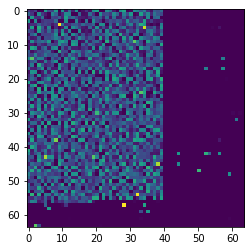

In [51]:
plt.imshow(dpe.read(2))

In [61]:
x = xs[0:400]

x1 = x[:,:57].T
x2 = x[:,57:].T

sc1 = x1.max()
sc2 = x2.max()

Gfc1 = nn.Gfc[:57]
Gfc2 = nn.Gfc[57:]

x1 = x1 / sc1
x2 = x2 / sc2

In [62]:
output1 = dpe.multiply(2, x1, c_sel=[0, 20])
software1 = (Gfc1.T @ x1).T 

Connecting to serial
[INFO] Elapsed time = 1.85s
Serial disconnected


In [63]:
output2 = dpe.multiply(2, x2, c_sel=[20, 40])
software2 = (Gfc2.T @ x2).T 

Connecting to serial
[INFO] Elapsed time = 1.88s
Serial disconnected


In [65]:
lin_cor_fc1 = []
lin_cor_fc2 = []
for c in range(20):
    lin_cor_fc1.append( np.polyfit(output1[:,c], software1[:,c], 1))
    lin_cor_fc2.append( np.polyfit(output2[:,c], software2[:,c], 1))

In [66]:
lin_cor_fc2

[array([1.50939670e+01, 2.60027365e-05]),
 array([ 1.66247109e+01, -5.40225403e-05]),
 array([ 1.72962790e+01, -1.56844273e-04]),
 array([ 1.75036894e+01, -1.26625396e-04]),
 array([ 1.59740256e+01, -8.57254315e-05]),
 array([ 1.71313470e+01, -1.24077458e-04]),
 array([ 1.75929409e+01, -1.05915387e-04]),
 array([ 1.81217626e+01, -3.48923021e-05]),
 array([1.57156064e+01, 2.27960055e-05]),
 array([ 1.66706404e+01, -1.46546485e-04]),
 array([ 1.82002855e+01, -3.22622302e-05]),
 array([ 1.62564313e+01, -8.18359533e-05]),
 array([ 1.70240905e+01, -3.03243738e-05]),
 array([ 1.70521872e+01, -4.34173990e-05]),
 array([1.39172700e+01, 1.16077778e-04]),
 array([1.56771686e+01, 2.95730299e-05]),
 array([1.78973037e+01, 1.03885526e-05]),
 array([ 1.83651714e+01, -1.69125805e-04]),
 array([1.54338415e+01, 8.79851817e-06]),
 array([ 1.68773581e+01, -1.92237114e-04])]

In [53]:
def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

Connecting to serial
[INFO] Elapsed time = 1.89s
Serial disconnected


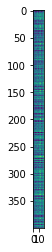

In [54]:
outputs  = dpe.multiply(2, x1, c_sel=[0, 20])
plt.imshow(outputs)
outputs = lin_corr(outputs, lin_cor_fc1)

In [14]:
lin_cor_fc1 = [
       [ 1.65705364e+01, -4.76661730e-06],
       [ 1.52014391e+01, -7.32910667e-06],
       [ 1.83622860e+01, -1.03660227e-04],
       [ 1.46453131e+01,  8.72582481e-05],
       [ 1.57026572e+01,  5.49433331e-06],
       [ 1.75302910e+01, -5.91984363e-05],
       [ 1.70097444e+01, -3.77425017e-06],
       [ 1.66811834e+01, -5.92705383e-05],
       [ 1.58138030e+01, -8.54206565e-05],
       [ 1.47224922e+01, -1.01580546e-04],
       [ 1.63933874e+01,  2.75899701e-05],
       [ 1.73734414e+01, -6.44827939e-05],
       [ 1.72284591e+01, -1.78498676e-05],
       [ 1.56514926e+01,  4.85230992e-05],
       [ 1.82551529e+01, -6.58699418e-05],
       [ 1.80427640e+01,  3.35214924e-05],
       [ 1.68846215e+01,  5.83922590e-05],
       [ 1.78382218e+01, -5.84954866e-05],
       [ 1.59426072e+01, -2.58419590e-05],
       [ 1.77145924e+01, -3.09111781e-04]]

lin_cor_fc2 = [
       [ 1.49074642e+01,  3.04496037e-05],
       [ 1.66134607e+01, -6.65273335e-05],
       [ 1.71330302e+01, -1.16174943e-04],
       [ 1.70197025e+01, -5.26536591e-05],
       [ 1.57107974e+01, -7.15197241e-05],
       [ 1.70294047e+01, -7.92741963e-05],
       [ 1.73580128e+01, -7.60909714e-05],
       [ 1.84105096e+01, -2.43281137e-05],
       [ 1.68061704e+01, -2.11947699e-05],
       [ 1.51725578e+01, -2.68254150e-05],
       [ 1.85076350e+01, -3.41438100e-05],
       [ 1.60115486e+01, -3.91897704e-05],
       [ 1.56633900e+01,  5.07271500e-05],
       [ 1.78045219e+01, -8.48122737e-05],
       [ 1.53011229e+01,  6.33155863e-05],
       [ 1.49990127e+01,  8.11595510e-05],
       [ 1.75060714e+01,  4.32311953e-05],
       [ 1.79812969e+01, -1.50383469e-04],
       [ 1.58391025e+01,  3.87391613e-06],
       [ 1.58795906e+01, -1.12594198e-04]]

In [80]:
output1  = dpe.multiply(2, x1, c_sel=[0, 20])
output1 = lin_corr(output1, lin_cor_fc1)

output2  = dpe.multiply(2, x2, c_sel=[20, 40])
output2 = lin_corr(output2, lin_cor_fc1)

outputs = output1 + output2

Connecting to serial
[INFO] Elapsed time = 1.88s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 1.85s
Serial disconnected


In [105]:
outputs = dpe.multiply(2, x2, c_sel=[20, 40])
outputs = lin_corr(outputs, lin_cor_fc2)
software = (Gfc2.T @ x2).T 

Connecting to serial
[INFO] Elapsed time = 4.09s
Serial disconnected


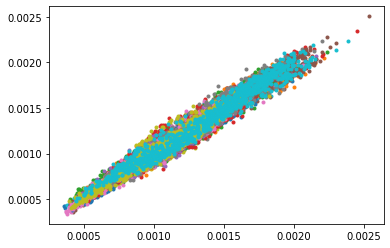

In [106]:
lin_cor_fc2 = []

for c in range(20):
    x = software[:,c]
    y = outputs[:,c]
    
    plt.plot(x,y,'.')

    lin_cor_fc2.append( np.polyfit(y, x, 1))

(array([1.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 9.000e+00, 7.000e+00,
        1.100e+01, 1.700e+01, 3.100e+01, 4.800e+01, 8.200e+01, 1.560e+02,
        1.850e+02, 2.730e+02, 3.590e+02, 4.590e+02, 5.850e+02, 7.030e+02,
        8.350e+02, 9.650e+02, 1.160e+03, 1.151e+03, 1.249e+03, 1.320e+03,
        1.369e+03, 1.313e+03, 1.332e+03, 1.216e+03, 1.043e+03, 9.620e+02,
        7.510e+02, 5.670e+02, 4.680e+02, 3.750e+02, 2.520e+02, 2.000e+02,
        1.590e+02, 1.050e+02, 7.900e+01, 5.100e+01, 3.700e+01, 3.000e+01,
        2.800e+01, 2.100e+01, 1.100e+01, 7.000e+00, 8.000e+00, 1.000e+00,
        3.000e+00, 3.000e+00]),
 array([-0.1076761 , -0.10325906, -0.09884201, -0.09442496, -0.09000791,
        -0.08559087, -0.08117382, -0.07675677, -0.07233973, -0.06792268,
        -0.06350563, -0.05908858, -0.05467154, -0.05025449, -0.04583744,
        -0.04142039, -0.03700335, -0.0325863 , -0.02816925, -0.02375221,
        -0.01933516, -0.01491811, -0.01050106, -0.00608402, -0.00166697,
         0.

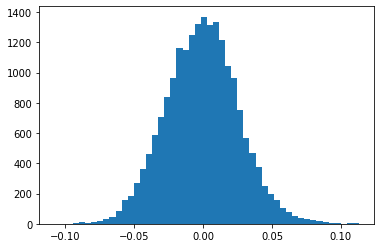

In [113]:
plt.hist((outputs-software).reshape(-1, 1)/0.0025, bins=50 )

In [112]:
(outputs-software).reshape(-1, 1).std()

6.573628287744503e-05

In [18]:
lin_cor_fc1 = [
       [ 1.65705364e+01, -4.76661730e-06],
       [ 1.52014391e+01, -7.32910667e-06],
       [ 1.83622860e+01, -1.03660227e-04],
       [ 1.46453131e+01,  8.72582481e-05],
       [ 1.57026572e+01,  5.49433331e-06],
       [ 1.75302910e+01, -5.91984363e-05],
       [ 1.70097444e+01, -3.77425017e-06],
       [ 1.66811834e+01, -5.92705383e-05],
       [ 1.58138030e+01, -8.54206565e-05],
       [ 1.47224922e+01, -1.01580546e-04],
       [ 1.63933874e+01,  2.75899701e-05],
       [ 1.73734414e+01, -6.44827939e-05],
       [ 1.72284591e+01, -1.78498676e-05],
       [ 1.56514926e+01,  4.85230992e-05],
       [ 1.82551529e+01, -6.58699418e-05],
       [ 1.80427640e+01,  3.35214924e-05],
       [ 1.68846215e+01,  5.83922590e-05],
       [ 1.78382218e+01, -5.84954866e-05],
       [ 1.59426072e+01, -2.58419590e-05],
       [ 1.77145924e+01, -3.09111781e-04]]

lin_cor_fc2 = [
       [ 1.49074642e+01,  3.04496037e-05],
       [ 1.66134607e+01, -6.65273335e-05],
       [ 1.71330302e+01, -1.16174943e-04],
       [ 1.70197025e+01, -5.26536591e-05],
       [ 1.57107974e+01, -7.15197241e-05],
       [ 1.70294047e+01, -7.92741963e-05],
       [ 1.73580128e+01, -7.60909714e-05],
       [ 1.84105096e+01, -2.43281137e-05],
       [ 1.68061704e+01, -2.11947699e-05],
       [ 1.51725578e+01, -2.68254150e-05],
       [ 1.85076350e+01, -3.41438100e-05],
       [ 1.60115486e+01, -3.91897704e-05],
       [ 1.56633900e+01,  5.07271500e-05],
       [ 1.78045219e+01, -8.48122737e-05],
       [ 1.53011229e+01,  6.33155863e-05],
       [ 1.49990127e+01,  8.11595510e-05],
       [ 1.75060714e+01,  4.32311953e-05],
       [ 1.79812969e+01, -1.50383469e-04],
       [ 1.58391025e+01,  3.87391613e-06],
       [ 1.58795906e+01, -1.12594198e-04]]

def lin_corr(outputs, factors):
    result = np.zeros(outputs.shape)
    for c in range(outputs.shape[1]):
        result[:,c] = outputs[:,c] * factors[c][0] + factors[c][1]
        
    return result

In [16]:
load_workspace(vars(), '20190820-055900-mnist_xs')
xs = np.array(xs)

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, linear_factors_conv, c, x, i, result, x1, y, xs, acc, 


In [67]:
ys = []
batch_size = 1000

for i in range( (len(test_images)-1)//batch_size + 1 ):
#     display.clear_output(wait=True)
    
    idx1 = i * batch_size
    idx2 = (i+1) * batch_size
    idx2 = idx2 if idx2<= len(test_images) else len(test_images)
    
    print(f'Running on sample {idx1}-{idx2}')

    x = xs[i*1000:(i+1)*1000]

    x1 = x[:,:57].T
    x2 = x[:,57:].T

    sc1 = x1.max()
    sc2 = x2.max()

    Gfc1 = nn.Gfc[:57]
    Gfc2 = nn.Gfc[57:]

    x1 = x1 / sc1
    x2 = x2 / sc2
    
    output1  = dpe.multiply(2, x1, c_sel=[0, 20])
    output1 = lin_corr(output1, lin_cor_fc1) * sc1

    output2  = dpe.multiply(2, x2, c_sel=[20, 40])
    output2 = lin_corr(output2, lin_cor_fc2) * sc2

    outputs = output1 + output2
    
    y = outputs[:,::2] - outputs[:,1::2]
    
    print(f'Accuracy = {np.mean(y.argmax(axis=1) == test_labels[idx1:idx2])*100:.2f}%')
    ys.append(y)
    
ys = np.concatenate(ys)  

Running on sample 0-1000
Connecting to serial
[INFO] Elapsed time = 4.17s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 4.13s
Serial disconnected
Accuracy = 91.80%
Running on sample 1000-2000
Connecting to serial
[INFO] Elapsed time = 4.00s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 4.10s
Serial disconnected
Accuracy = 90.20%
Running on sample 2000-3000
Connecting to serial
[INFO] Elapsed time = 4.13s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 4.10s
Serial disconnected
Accuracy = 89.60%
Running on sample 3000-4000
Connecting to serial
[INFO] Elapsed time = 4.16s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 4.14s
Serial disconnected
Accuracy = 89.90%
Running on sample 4000-5000
Connecting to serial
[INFO] Elapsed time = 4.18s
Serial disconnected
Connecting to serial
[INFO] Elapsed time = 4.15s
Serial disconnected
Accuracy = 89.90%
Running on sample 5000-6000
Connecting to serial
[INFO] Elapsed time = 4.14s
Serial

In [68]:
np.mean(ys.argmax(axis=1) == test_labels)

0.926

In [29]:
ynew.argmax(axis=1) == test_labels

array([ True,  True, False, ...,  True,  True,  True])

In [5]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

Array 1 , device (row= 0 col= 0 ) Init G= 9.733968719452589e-05  Target G= 2.9341765184653923e-05  Final G= 2.7918866080156413e-05
Array 1 , device (row= 1 col= 0 ) Init G= 6.302394916911047e-05  Target G= 2.4320306692970917e-05  Final G= 2.6208211143695024e-05
Array 1 , device (row= 2 col= 0 ) Init G= 3.510361681329423e-05  Target G= 9.42114638746716e-06  Final G= 1.5858748778103628e-05
Array 1 , device (row= 3 col= 0 ) Init G= 4.2615835777126094e-05  Target G= 5.051698735769605e-06  Final G= 2.8809384164222873e-06
Array 1 , device (row= 4 col= 0 ) Init G= 0.00011427826653633111  Target G= 8.179570613719989e-06  Final G= 5.080009775171065e-05
Array 1 , device (row= 5 col= 0 ) Init G= 8.028690127077223e-05  Target G= 4.1807554225670174e-05  Final G= 3.8595796676441836e-05
Array 1 , device (row= 6 col= 0 ) Init G= 5.746432062561095e-05  Target G= 1.9999999949504854e-06  Final G= 5.016324535679374e-06
Array 1 , device (row= 7 col= 0 ) Init G= -3.5219941348973436e-07  Target G= 4.07888364

NameError: name 'save_workspace' is not defined

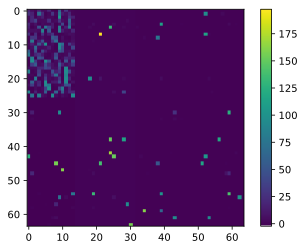

In [6]:
VreadGate = 5.0
vRead = 0.2
arr = 1
startRow = 0
startCol = 0
numRows = 26
numCols = 14
GMin = 2e-6
GMax = 100e-6

targetGVals = finalGconv
targetGThresh = 4e-6
targetRows = np.arange(startRow, startRow+numRows)
targetCols = np.arange(startCol, startCol+numCols)

vAppliedSet = np.arange(0.5, 2.5, 0.1)
vAppliedReset = np.arange(0.5, 3.5, 0.1)
vGateSet = np.arange(0.5, 1.7, 0.05)
vGateReset = np.arange(5.0, 5.5, 0.5)

gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.3e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])

GHistory = []
VHistory = []

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.3, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vgate = 5
Vref = 0.5

for j in range(numCols):
    cc = targetCols[j]
    for i in range(numRows):
        rr = targetRows[i]
        #print('Working on array', arr, ', device (row=', rr, 'col=', cc, ')')
        thisGtarget = targetGVals[i,j]
        thisGHistory = []
        thisVHistory = []
        thisGainHistory = []
        # Do a first read of this device
        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
        VADC_read_first = dut.adc2volt(adc_raw)
        gainFirst = adc_raw >> 10
        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        # Now, if device is lower than target, SET it
        if currG < (thisGtarget-targetGThresh):
            for vgate in vGateSet:
                for vappset in vAppliedSet:
                    # Apply vappset pulse, then read
                    a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                
                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(vappset)
                    if currG >= (thisGtarget-targetGThresh):
                        break
                if currG >= (thisGtarget-targetGThresh):
                    break
            GHistory.append(thisGHistory)
            VHistory.append(thisVHistory)

        # Else, if device is higher than target, RESET it, then SET it
        elif currG > (thisGtarget+targetGThresh):
            for vgate in vGateReset:
                for vappreset in vAppliedReset:
                    # Apply vappreset pulse, then read
                    a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]

                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(-1*vappreset)
                    if currG <= (thisGtarget+targetGThresh):
                        break
                if currG <= (thisGtarget+targetGThresh):
                    break

            #Now if it is below Gtarget, then do SET operations; If it is above Gtarget, then Reset failed and device stuck ON
            
            #if currG <= thisGtarget and thisGtarget >= 2.5e-6:
            if currG <= (thisGtarget-targetGThresh):
                for vgate in vGateSet:
                    for vappset in vAppliedSet:
                        # Apply vappset pulse, then read
                        a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                        VADC_read_first = dut.adc2volt(adc_raw)
                        gainFirst = adc_raw >> 10
                        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                    
                        currG = rdCurr/vRead
                        thisGHistory.append(currG)
                        thisVHistory.append(vappset)
                        if currG >= (thisGtarget-targetGThresh):
                            break
                    if currG >= (thisGtarget-targetGThresh):
                        break

        GHistory.append(thisGHistory)
        VHistory.append(thisVHistory)
        print('Array', arr, ', device (row=', rr, 'col=', cc, ') Init G=', initG, ' Target G=', thisGtarget, ' Final G=', currG)
        
time.sleep(15)
arr = 1
numRows = 64
numCols = 64
vRead = 0.2
vReadGate = 5.0
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
Gmap1post = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
            VADC_read_first = dut.adc2volt(adc_raw)
            gainFirst = adc_raw >> 10
            secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
            secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
            dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
            VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
            finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
            dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
            rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
            Gmap1post[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmap1post)
plt.colorbar()

time.sleep(15)
save_workspace(vars(), note='Prober1_UpdatedConv_Progr_ARRAY1')

VreadGate = 5.0
vRead = 0.2
arr = 1
startRow = 26
startCol = 14
numRows = 26
numCols = 14
GMin = 2e-6
GMax = 100e-6

targetGVals = finalGconv
targetGThresh = 4e-6
targetRows = np.arange(startRow, startRow+numRows)
targetCols = np.arange(startCol, startCol+numCols)

vAppliedSet = np.arange(0.5, 2.5, 0.1)
vAppliedReset = np.arange(0.5, 3.5, 0.1)
vGateSet = np.arange(0.5, 1.7, 0.05)
vGateReset = np.arange(5.0, 5.5, 0.5)

gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.3e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])

GHistory2 = []
VHistory2 = []

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.3, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vgate = 5
Vref = 0.5

for j in range(numCols):
    cc = targetCols[j]
    for i in range(numRows):
        rr = targetRows[i]
        #print('Working on array', arr, ', device (row=', rr, 'col=', cc, ')')
        thisGtarget = targetGVals[i,j]
        thisGHistory = []
        thisVHistory = []
        thisGainHistory = []
        # Do a first read of this device
        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
        VADC_read_first = dut.adc2volt(adc_raw)
        gainFirst = adc_raw >> 10
        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        # Now, if device is lower than target, SET it
        if currG < (thisGtarget-targetGThresh):
            for vgate in vGateSet:
                for vappset in vAppliedSet:
                    # Apply vappset pulse, then read
                    a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                
                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(vappset)
                    if currG >= (thisGtarget-targetGThresh):
                        break
                if currG >= (thisGtarget-targetGThresh):
                    break
            GHistory.append(thisGHistory)
            VHistory.append(thisVHistory)

        # Else, if device is higher than target, RESET it, then SET it
        elif currG > (thisGtarget+targetGThresh):
            for vgate in vGateReset:
                for vappreset in vAppliedReset:
                    # Apply vappreset pulse, then read
                    a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]

                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(-1*vappreset)
                    if currG <= (thisGtarget+targetGThresh):
                        break
                if currG <= (thisGtarget+targetGThresh):
                    break

            #Now if it is below Gtarget, then do SET operations; If it is above Gtarget, then Reset failed and device stuck ON
            
            #if currG <= thisGtarget and thisGtarget >= 2.5e-6:
            if currG <= (thisGtarget-targetGThresh):
                for vgate in vGateSet:
                    for vappset in vAppliedSet:
                        # Apply vappset pulse, then read
                        a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                        VADC_read_first = dut.adc2volt(adc_raw)
                        gainFirst = adc_raw >> 10
                        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                    
                        currG = rdCurr/vRead
                        thisGHistory.append(currG)
                        thisVHistory.append(vappset)
                        if currG >= (thisGtarget-targetGThresh):
                            break
                    if currG >= (thisGtarget-targetGThresh):
                        break

        GHistory2.append(thisGHistory)
        VHistory2.append(thisVHistory)
        print('Array', arr, ', device (row=', rr, 'col=', cc, ') Init G=', initG, ' Target G=', thisGtarget, ' Final G=', currG)
        
time.sleep(15)
arr = 1
numRows = 64
numCols = 64
vRead = 0.2
vReadGate = 5.0
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
Gmap1post2 = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
            VADC_read_first = dut.adc2volt(adc_raw)
            gainFirst = adc_raw >> 10
            secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
            secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
            dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
            VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
            finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
            dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
            rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
            Gmap1post2[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmap1post2)
plt.colorbar()

time.sleep(15)
save_workspace(vars(), note='Prober1_UpdatedConv_Progr_ARRAY12')

(26, 14)

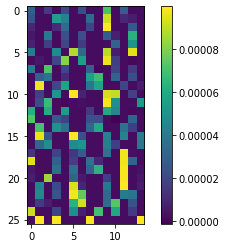

In [71]:
plt.imshow(finalGconv)
plt.colorbar()
np.shape(finalGconv)

In [4]:
import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *
vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)

In [2]:

import dut_func as dut
import serial
import time
import struct
import numpy as np
# from bitarray import bitarray
from bitstring import BitArray
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
import dut_a0 as a0

from misc import *

# dut.drv.serUSB = 'COM19'
drv = dut.drv

ser = serial.Serial('COM6', 9600, timeout=2)
dut.connect(ser)

In [3]:
dut.power_on()
dut.reset_chip()
dut.reset_dpe()

Setting vrefs to default
DAC initialized to a span from -10 V to 10 V


In [8]:
from lib_data import *
save_workspace(vars(), note='Prober1_UpdatedConv_Progr_ARRAY1')

Saving In(<class 'list'>), Out(<class 'dict'>), PIC_PINS(<class 'dict'>), DAC_CH(<class 'dict'>), DAC_SPAN(<class 'dict'>), REFCLKO(<class 'dict'>), vOffset(<class 'float'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), VreadGate(<class 'float'>), vRead(<class 'float'>), arr(<class 'int'>), startRow(<class 'int'>), startCol(<class 'int'>), numRows(<class 'int'>), numCols(<class 'int'>), GMin(<class 'float'>), GMax(<class 'float'>), targetGVals(<class 'numpy.ndarray'>), targetGThresh(<class 'float'>), targetRows(<class 'numpy.ndarray'>), targetCols(<class 'numpy.ndarray'>), vAppliedSet(<class 'numpy.ndarray'>), vAppliedReset(<class 'numpy.ndarray'>), vGateSet(<class 'numpy.ndarray'>), vGateReset(<class 'numpy.ndarray'>), gains(<class 'numpy.ndarray'>), maxCurr(<class 'numpy.ndarray'>), GHistory(<class 'list'>), VHistory(<class 'list'>), VADC_boundary(<class 'numpy.ndarray'>), VRefHiCmp(<class 'numpy.ndarray'>), Vgate(<class 'int'>), Vref(<class 'float'>), j(<class 

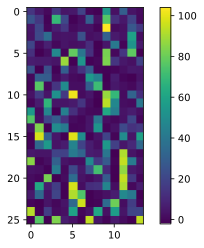

In [12]:
plt.imshow(Gmap1post[:26,:14])
plt.colorbar()

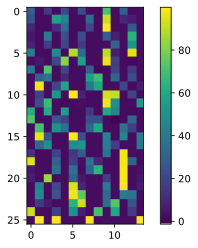

In [13]:
plt.imshow(finalGconv*1e6)
plt.colorbar()

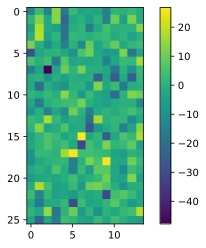

In [14]:
plt.imshow(Gmap1post[:26,:14]-finalGconv*1e6)
plt.colorbar()

Array 1 , device (row= 26 col= 14 ) Init G= -3.5219941348973436e-07  Target G= 2.9341765184653923e-05  Final G= 3.0042521994134896e-05
Array 1 , device (row= 27 col= 14 ) Init G= -3.5219941348973436e-07  Target G= 2.4320306692970917e-05  Final G= 3.463440860215053e-05
Array 1 , device (row= 28 col= 14 ) Init G= -4.5483870967741755e-07  Target G= 9.42114638746716e-06  Final G= 1.508895405669599e-05
Array 1 , device (row= 29 col= 14 ) Init G= -4.890518084066463e-07  Target G= 5.051698735769605e-06  Final G= 5.324242424242424e-06
Array 1 , device (row= 30 col= 14 ) Init G= -5.574780058651019e-07  Target G= 8.179570613719989e-06  Final G= 0.00038532746823069405
Array 1 , device (row= 31 col= 14 ) Init G= -5.916911045943296e-07  Target G= 4.1807554225670174e-05  Final G= 4.5709677419354836e-05
Array 1 , device (row= 32 col= 14 ) Init G= -6.259042033235574e-07  Target G= 1.9999999949504854e-06  Final G= -6.259042033235574e-07
Array 1 , device (row= 33 col= 14 ) Init G= -6.259042033235574e-07

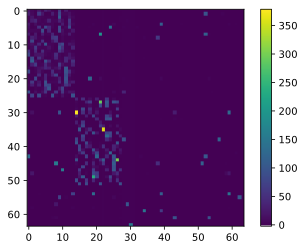

In [15]:
import scipy.io as sio
#load_workspace(vars(), '20190814-205207-CNN weights')
mat_contents = sio.loadmat('UpdatedGconv.mat')
finalGconv = mat_contents['finalGconv']

VreadGate = 5.0
vRead = 0.2
arr = 1
startRow = 26
startCol = 14
numRows = 26
numCols = 14
GMin = 2e-6
GMax = 100e-6

targetGVals = finalGconv
targetGThresh = 4e-6
targetRows = np.arange(startRow, startRow+numRows)
targetCols = np.arange(startCol, startCol+numCols)

vAppliedSet = np.arange(0.5, 2.5, 0.1)
vAppliedReset = np.arange(0.5, 3.5, 0.1)
vGateSet = np.arange(0.5, 1.7, 0.05)
vGateReset = np.arange(5.0, 5.5, 0.5)

gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.3e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])

GHistory2 = []
VHistory2 = []

VADC_boundary = np.array([0.4, 1.692, 1.927, 2.247, 2.645, 3.045, 3.391, 3.688, 4.1])
VRefHiCmp = np.array([5.3, 4.5, 4.2, 3.8, 3.4, 3.0, 2.7, 2.4])

_gain_ratio = [
    1e3,
    5e3,
    30e3,
    200e3,
    1e6
]

vOffset = -0.08
dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
Vgate = 5
Vref = 0.5

for j in range(numCols):
    cc = targetCols[j]
    for i in range(numRows):
        rr = targetRows[i]
        #print('Working on array', arr, ', device (row=', rr, 'col=', cc, ')')
        thisGtarget = targetGVals[i,j]
        thisGHistory = []
        thisVHistory = []
        thisGainHistory = []
        # Do a first read of this device
        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
        VADC_read_first = dut.adc2volt(adc_raw)
        gainFirst = adc_raw >> 10
        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
        currG = rdCurr/vRead
        thisGHistory.append(currG)
        thisVHistory.append(0)
        #print('Initial G=', currG, 'Target G =', thisGtarget)
        initG = currG
        # Now, if device is lower than target, SET it
        if currG < (thisGtarget-targetGThresh):
            for vgate in vGateSet:
                for vappset in vAppliedSet:
                    # Apply vappset pulse, then read
                    a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                
                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(vappset)
                    if currG >= (thisGtarget-targetGThresh):
                        break
                if currG >= (thisGtarget-targetGThresh):
                    break
            GHistory.append(thisGHistory)
            VHistory.append(thisVHistory)

        # Else, if device is higher than target, RESET it, then SET it
        elif currG > (thisGtarget+targetGThresh):
            for vgate in vGateReset:
                for vappreset in vAppliedReset:
                    # Apply vappreset pulse, then read
                    a0.reset_single_int(vappreset, vgate, array=arr, row=rr, col=cc)

                    adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                    VADC_read_first = dut.adc2volt(adc_raw)
                    gainFirst = adc_raw >> 10
                    secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                    secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                    dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                    VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                    finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                    dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                    rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]

                    currG = rdCurr/vRead
                    thisGHistory.append(currG)
                    thisVHistory.append(-1*vappreset)
                    if currG <= (thisGtarget+targetGThresh):
                        break
                if currG <= (thisGtarget+targetGThresh):
                    break

            #Now if it is below Gtarget, then do SET operations; If it is above Gtarget, then Reset failed and device stuck ON
            
            #if currG <= thisGtarget and thisGtarget >= 2.5e-6:
            if currG <= (thisGtarget-targetGThresh):
                for vgate in vGateSet:
                    for vappset in vAppliedSet:
                        # Apply vappset pulse, then read
                        a0.set_single_int(vappset, vgate, array=arr, row=rr, col=cc)

                        adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
                        VADC_read_first = dut.adc2volt(adc_raw)
                        gainFirst = adc_raw >> 10
                        secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
                        secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
                        dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
                        VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
                        finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
                        dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
                        rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
                    
                        currG = rdCurr/vRead
                        thisGHistory.append(currG)
                        thisVHistory.append(vappset)
                        if currG >= (thisGtarget-targetGThresh):
                            break
                    if currG >= (thisGtarget-targetGThresh):
                        break

        GHistory2.append(thisGHistory)
        VHistory2.append(thisVHistory)
        print('Array', arr, ', device (row=', rr, 'col=', cc, ') Init G=', initG, ' Target G=', thisGtarget, ' Final G=', currG)
        
time.sleep(15)
arr = 1
numRows = 64
numCols = 64
vRead = 0.2
vReadGate = 5.0
gains = np.array([4, 3, 2, 1, 0])
maxCurr = np.array([3.2e-3, 650e-6, 110e-6, 14.0e-6, 3.3e-6])
Gmap1post2 = np.zeros((numRows, numCols))
for rr in range(numRows):
        for cc in range(numCols):
            adc_raw = a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=-1, raw=True)
            VADC_read_first = dut.adc2volt(adc_raw)
            gainFirst = adc_raw >> 10
            secondVRefHiCmpIndex = np.searchsorted(VADC_boundary,VADC_read_first)-1
            secondVRefHiCmp = VRefHiCmp[secondVRefHiCmpIndex]+vOffset
            dut.dac_set('DAC_VREF_HI_CMP', secondVRefHiCmp+vOffset) 
            VADC_read_sec = dut.adc2volt(a0.read_single_int(vRead, Vgate, array=arr, row=rr, col=cc, gain=gainFirst, raw=True))
            finalADCOut = VADC_read_sec - (secondVRefHiCmp - 4.0) 
            dut.dac_set('DAC_VREF_HI_CMP', 4.0+vOffset)
            rdCurr = (finalADCOut - 0.5) / _gain_ratio[gainFirst]
        
            Gmap1post2[rr,cc] = 1e6*rdCurr/vRead
plt.imshow(Gmap1post2)
plt.colorbar()

time.sleep(15)
save_workspace(vars(), note='Prober1_UpdatedConv_Progr_ARRAY12')

In [16]:
dut.disconnect()